---
title: Inflation Regimes in Latin America, 2020-2022
subtitle: Persistence, Determinants, and Dynamics
---

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from fractions import Fraction
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

g = globals()
plt.style.use('ggplot')

## Data

In [137]:
# Define lists for variables and countries
vars = ['cpi', 'm2', 'mpr', 'er']
countries = ['arg', 'bra', 'chl', 'col', 'cri', 'mex']

In [138]:
#Data

#SIE
#5sep2023
#cpi, m2, mpr
sie_columns = {
    '[Fecha]':'date',
    '[ARGENTINA]':'arg',
    '[BRASIL]':'bra',
    '[CHILE]':'chl',
    '[COLOMBIA]':'col',
    '[COSTA RICA]':'cri',
    '[MEXICO]':'mex'}

sie_vars = ['cpi','m2','mpr']

for x in sie_vars:
    g[x] = pd.read_excel(f'./data/%s.xlsx' % x, 
        header=1,
        usecols=sie_columns.keys()
        ).rename(columns=sie_columns
        ).set_index('date').dropna(how='all')
    g[x].index = pd.PeriodIndex(g[x].index, freq='M')

#FRED (CPIAUCSL)
#5sep2023
#uscpi
uscpi = pd.read_excel('./data/uscpi.xls',
        header=10
        ).rename(columns={'observation_date':'date','CPIAUCSL':'uscpi'}
        ).set_index('date')
uscpi.index = pd.PeriodIndex(uscpi.index, freq='M')

#OECD
#5sept2023
#er
erd = pd.read_csv('./data/er.csv',
    usecols=['LOCATION','TIME','Value']
    ).rename(columns={
        'LOCATION':'country','TIME':'date','Value':'er'}
        ).set_index('date')
erd.index = pd.PeriodIndex(erd.index, freq='M')

er = pd.DataFrame()
for c in countries:
    er[c] = erd[erd['country']==c.upper()]['er'].dropna()

#OECD (no están en la base)
#6sept2023
#Millones
#Q
#Final consumption expenditure
    #Private
    #General Government
#Gross capital formation
#CQRSA: National currency, current prices, quarterly levels, seasonally adjusted
oecd = pd.read_csv('./data/cons.csv',
    usecols=['LOCATION','Subject','TIME','Value']
    ).rename(columns={
        'LOCATION':'country','Subject':'subj','TIME':'date','Value':'value'}
        ).set_index('date').replace(
        {'Final consumption expenditure':'cons',
        'Private final consumption expenditure':'privcons',
        'General government final consumption expenditure':'govcons',
        'Gross capital formation':'gcf'}
        )
oecd.index = pd.PeriodIndex(oecd.index, freq='Q')

Mensuales
* Columns: countries
* Index1: variables
* Index2: date

Input: **base**, incluye todas las variables **originales**, de todos los países y con NaN

In [139]:
base = pd.concat([cpi,m2,mpr,er], keys=vars)

* Panel con todas
* Def para cada país
* Definir una función que incluya el análisis de los países (extensión del punto anterior)

Interfaz que permita elegir las variables a utilizar

**Avisar SIE de error**

- df_: datos originales, fechas que hay todos
- dfm_: modificaciones, fechas para el estudio

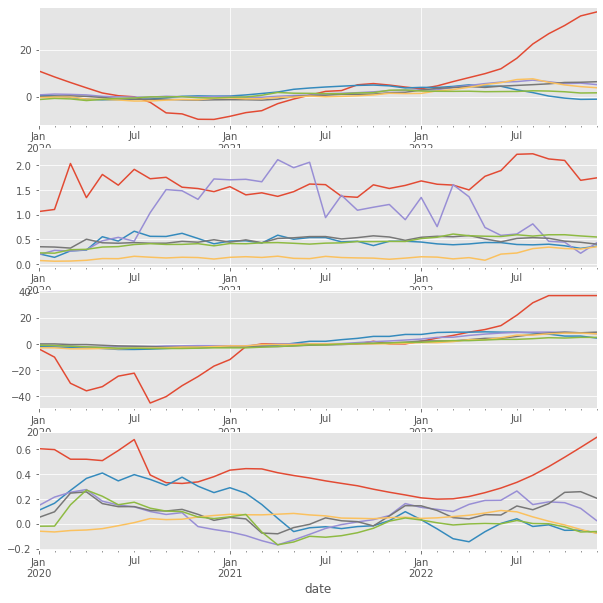

In [607]:
#df_
for c in countries:
    g['df_%s' % c] = pd.DataFrame()
    for v in vars:
        g['df_%s' % c][v] = base[c][v].dropna()
    g['df_%s' % c].dropna(inplace=True) #deja solo las observaciones con todas las variables

#Alternativa para merge
#reduce(lambda left,right:pd.merge(left,right,on='date'), dfs).set_axis(vars, axis=1)

#Limitar años
initial_date = '2020-01'
final_date = '2022-12'

#df_m
for c in countries:
    g['dfm_%s' % c] = pd.DataFrame()
    g['dfm_%s' % c]['cpi'] = (
        ((g['df_%s' % c]['cpi'].dropna().pct_change(12)+1) -
        (g['df_%s' % c]['cpi'].dropna().pct_change(36)+1)**(Fraction(1/3))
        )*100).dropna()

    g['dfm_%s' % c]['m2'] = (
        (g['df_%s' % c]['m2'].dropna().pct_change(36))
    ).dropna()

    g['dfm_%s' % c]['mpr'] = (
        g['df_%s' % c]['mpr'].dropna().diff(12)
    ).dropna()

    g['dfm_%s' % c]['er'] = (
        g['df_%s' % c]['er'].dropna().pct_change(12)
    ).dropna()

    g['dfm_%s' % c] = g['dfm_%s' % c]['2020-01':'2022-12']

#Limitar años
initial_date = '2020-01'
final_date = '2022-12'



#Graficar todas las series 5//2,5%2
fig_originals, ax_originals = plt.subplots(4, figsize=(10,10)) 
for v in range(len(vars)):
    for c in countries:
        g['dfm_%s' % c][vars[v]][initial_date:final_date].plot(
            ax=ax_originals[v], label=c)

Desestacionalización? Nominal, real? Diferencias normales o logarítmicas?

## Inflationary Regimes and Persistence

* State transition, A
* Observation model, B
* Initial state distribution, $\pi$

In [615]:
for c in countries:
    g['dfm_%s' % c]['v'] = 0 #visto

    g['dfm_%s' % c]['v'].mask(
        (g['dfm_%s' % c]['cpi']>=0) &
        (g['dfm_%s' % c]['cpi']<2),
        1, inplace=True
        )

    g['dfm_%s' % c]['v'].mask(
        (g['dfm_%s' % c]['cpi']>=2) &
        (g['dfm_%s' % c]['cpi']<5),
        2, inplace=True
        )

    g['dfm_%s' % c]['v'].mask(
        g['dfm_%s' % c]['cpi']>=4,
        3, inplace=True
        )

falta el menor score posible

In [673]:
A = np.array(
[
    [0.85,0.05,0.05,0.05],
    [0.10,0.70,0.15,0.05],
    [0.15,0.10,0.65,0.10],
    [0.05,0.05,0.05,0.85]
])

B = np.array(
[
    [0.70,0.10,0.10,0.10],
    [0.15,0.50,0.25,0.10],
    [0.10,0.10,0.70,0.10],
    [0.10,0.10,0.10,0.70]
])

n_iter = 10000

for c in countries:
    g['model_%s' % c] = hmm.CategoricalHMM(n_components=4, 
        n_iter=n_iter,
        params='et',
        init_params='',
        tol=0,
        random_state=None)

    g['model_%s' % c].transmat_= A
    g['model_%s' % c].emissionmat_= B

    print(c, g['model_%s' % c].fit([g['dfm_%s' % c]['v']]).transmat_.round(3)*100)
    print(c, g['model_%s' % c].fit([g['dfm_%s' % c]['v']]).score([g['dfm_%s' % c]['v']]))

arg [[100.    0.    0.    0. ]
 [  0.   66.7  33.3   0. ]
 [ 15.    0.   70.   15. ]
 [  0.    0.   10.   90. ]]
arg -20.166017394834537
bra [[91.4  8.6  0.   0. ]
 [ 0.  82.5  0.  17.5]
 [59.4  0.  40.6  0. ]
 [ 0.   0.   6.3 93.7]]
bra -26.685539024685855
chl [[ 60.    0.   40.    0. ]
 [  0.  100.    0.    0. ]
 [  0.   40.   60.    0. ]
 [  4.8   0.    0.   95.2]]
chl -18.725167570883354
col [[ 66.7   0.    0.   33.3]
 [  0.   91.7   8.3   0. ]
 [  8.3   8.3  83.3   0. ]
 [  0.    0.    0.  100. ]]
col -12.770441515372559
cri [[ 93.7   0.    0.    6.3]
 [ 39.3  20.7  39.9   0. ]
 [  0.    0.  100.    0. ]
 [  0.   12.5   0.   87.5]]
cri -14.469865251297893
mex [[91.7  0.   0.   8.3]
 [ 0.  81.8  0.  18.2]
 [23.6  0.  76.4  0. ]
 [ 0.  12.9 15.1 72. ]]
mex -17.95887341276972


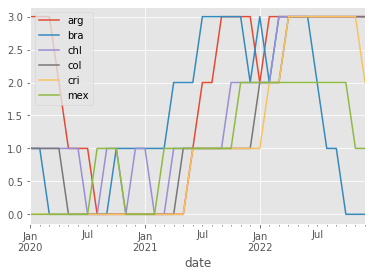

In [651]:
for c in countries:
    g['dfm_%s' % c]['v']['2020-01':].plot(label=c)
    plt.legend()